## Zadatak 1

In [1]:
import pyaudio
import wave
import time
# ova tri modula su potrebna ako se snima sekvenca
import numpy as np
import matplotlib.pyplot as plt
# za ucitavanje wav fajla
from scipy.io import wavfile
import scipy.io
# za bandpass filtriranje
from scipy import signal
# za otsu-ovu granicu
from skimage import filters
# za peakove
from scipy.signal import find_peaks
import math

Za početak treba učitati govornu sekvencu. To se radi na sledeći način. Radi jednostavnosti izvođenja ovog domaćeg, ja ću prvi put da izvršim ovaj kod i napraviti fajl koji se zove myrecording.wav. Kasnije ću uvek učitavati taj isti fajl (da ne moram svaki put da generišem novu govornu sekvencu).

In [2]:
"""audio = pyaudio.PyAudio()
stream = audio.open(format=pyaudio.paInt16, channels=1, rate=8000, input=True, frames_per_buffer=1024)
frames = []

t_end = time.time() + 20
print('Krece')
while time.time() < t_end:
    data = stream.read(1024)
    frames.append(data)
print('Kraj')
stream.stop_stream()
stream.close()
audio.terminate()

sound_file = wave.open("myrecording.wav", "wb")
sound_file.setnchannels(1)
sound_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
sound_file.setframerate(8000)
sound_file.writeframes(b''.join(frames))
sound_file.close()
"""

'audio = pyaudio.PyAudio()\nstream = audio.open(format=pyaudio.paInt16, channels=1, rate=8000, input=True, frames_per_buffer=1024)\nframes = []\n\nt_end = time.time() + 20\nprint(\'Krece\')\nwhile time.time() < t_end:\n    data = stream.read(1024)\n    frames.append(data)\nprint(\'Kraj\')\nstream.stop_stream()\nstream.close()\naudio.terminate()\n\nsound_file = wave.open("myrecording.wav", "wb")\nsound_file.setnchannels(1)\nsound_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))\nsound_file.setframerate(8000)\nsound_file.writeframes(b\'\'.join(frames))\nsound_file.close()\n'

Ucitavanje govorne sekvence. Promenljiva samplerate vraca frekvenciju odabiranja, a data je govorni signal.

In [3]:
samplerate, data = wavfile.read("myrecording.wav")
# normalizacija
data = data/np.max(abs(data))

Text(0.5, 1.0, 'U vremenskom domenu')

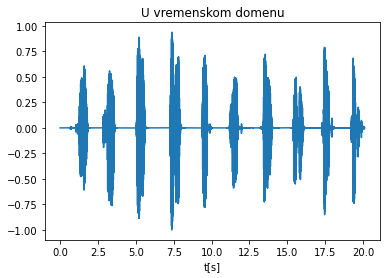

In [4]:
t = np.arange(data.size)/8000
plt.plot(t, data)
plt.xlabel('t[s]')
plt.title('U vremenskom domenu')

Ovako izgleda govorna sekvenca u vremenskom domenu. Odabiranje je rađeno na 8000Hz, a govor sadrži 10 reči (brojeve od 1 do 10).

Pre bilo kakve analize potrebno je filtrirati signal highpass filtrom od 60 da bi se DC komponenta otklonila.

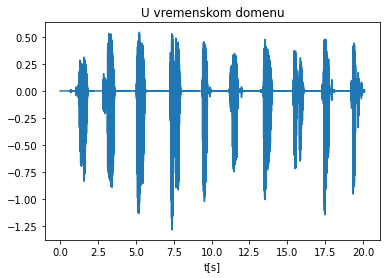

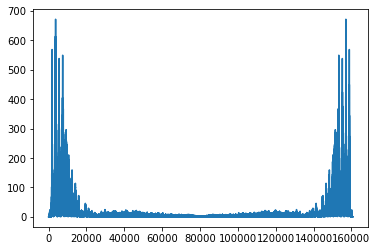

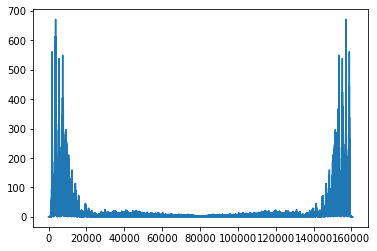

In [5]:
sos = signal.butter(4, 60, btype='highpass', analog=False, fs=8000, output='sos')
filtered = signal.sosfilt(sos, data)
plt.plot(t, filtered)
plt.xlabel('t[s]')
plt.title('U vremenskom domenu')

sp1 = np.fft.fft(data)
sp2 = np.fft.fft(filtered)
plt.figure()
plt.plot(abs(sp1))

plt.figure()
plt.plot(abs(sp2))


Potrebno je segmentisati reči pomoću kratkovremenske energije. Formula za kratkovremensku energiju je:
$$E_n = \sum^{\infty}_{m=-\infty}x^2[m]\cdot w[n-m]$$
Za prozorsku funkciju koristim Hamming-ovu funkciju. Za dužinu prozorske funkcije ću staviti $20ms$. Pošto je frekvencija $8000Hz$, to znači da je $Ts=0.000125s$, to znači da prozorska funkcija ima $200$ odbiraka.

Text(0.5, 1.0, 'Hamming-ova prozorska funkcija')

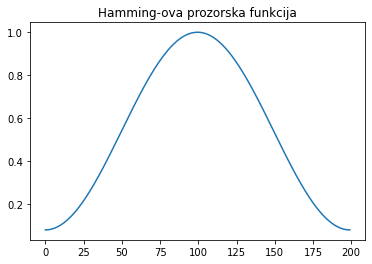

In [6]:
wind = np.hamming(200)
plt.plot(wind)
plt.title('Hamming-ova prozorska funkcija')

Text(0.5, 1.0, 'Kratkovremenska energija')

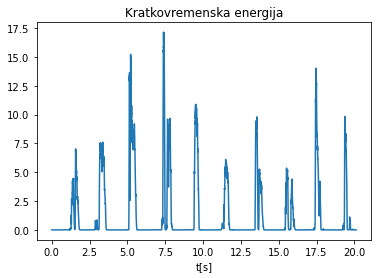

In [7]:
short_time_energy = np.convolve(filtered**2, wind)
time1 = np.arange(short_time_energy.size)/8000
plt.plot(time1, short_time_energy)
plt.xlabel('t[s]')
plt.title('Kratkovremenska energija')

Sada treba napraviti kratkovremenski zero-cross-rate. Formula za ZCR:
$$ZCR_n = \sum^{\infty}_{m=-\infty} |sgn(x[n])-sgn(n-1)| \cdot w[n-m]$$
Za ZCR koristim pravougaoni prozor sa 50 odbiraka.

Text(0.5, 1.0, 'Kratkovremenski ZCR')

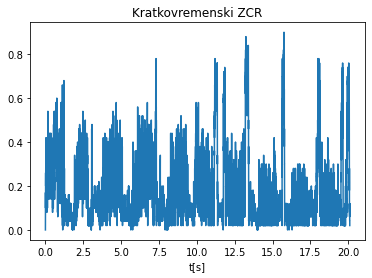

In [8]:
sgn = np.sign(filtered)
new_sgn = np.zeros(sgn.size-1)
for i in range(1, sgn.size):
    new_sgn[i-1] = abs(sgn[i]-sgn[i-1])
wind = np.ones(50)/100

short_time_zcr = np.convolve(new_sgn, wind)
time1 = np.arange(short_time_zcr.size)/8000
plt.plot(time1, short_time_zcr)
plt.xlabel('t[s]')
plt.title('Kratkovremenski ZCR')

Kratkovremenski ZCR bi trebalo da bude velik tamo gde nema reči, što je suprotno od kratkovremenske energije. To i možemo da vidimo na ovim graficima.

Za segmentaciju govornog signala ću koristiti Rabinerov metod. Sa grafika se vidi da je energija reči dosta visoka, pa sam stavio $IMN=0.25$, a $IMX=max(energija)$. Za određivanje donje i gornje granice koristim:
$$I1=0.3 \cdot (IMX-IMN) + IMN$$
$$I2=4 \cdot IMN$$
Donja granica:
$$ITL=min(I1,I2)$$
Gornja Granica:
$$ITU=5 \cdot ITL$$

Text(0.5, 0, 't[s]')

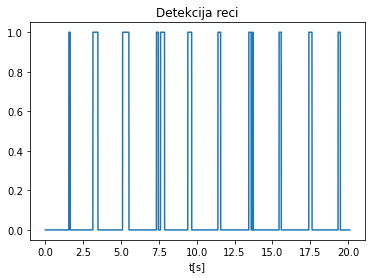

In [9]:
imx = np.max(short_time_energy)
imn = 0.25
i1 = 0.3*(imx-imn) + imn
i2 = 4*imn
itl = min(i1, i2)
itu = 5* itl
ok = False
start = []
end = []

# trazenje preseka sa gornjom granicom
for i in range(short_time_energy.size):
    if not ok and short_time_energy[i]>itu:
        start.append(i)
        ok = True
    if ok and short_time_energy[i]<itu:
        end.append(i)
        ok = False
        
start1 = []
end1 = []
# trazenje preseka sa donjom granicom pre i posle preseka sa gornjom
for s in start:
    for i in range(s):
        if short_time_energy[s-i]<itl:
            start1.append(s-i)
            break

for e in end:
    for i in range(short_time_energy.size - e):
        if short_time_energy[e+i]<itu:
            end1.append(e+i)
            break

# segmentacija govora
speech = np.zeros(short_time_energy.shape)
for i in range(len(start1)):
    for j in range(start1[i], end1[i]):
        speech[j]=1

t = np.arange(speech.size)/8000
plt.plot(t, speech)
plt.title('Detekcija reci')
plt.xlabel('t[s]')

Na grafiku je dato kada je reč segmentisana, a kada nije (1 znači da jeste reč, 0 da nije). I bez popravke je segmentacija solidno dobra. Međutim javljaju se problemi kod nekih reči da se reč podeli na više delova. Ovako smo dobili 21 reč umesto 10. Zbog toga je potrebno uvesti neke popravke. Jedna od tih popravki je uz pomoć ZCR-a govornog signala. Potrebno je prvo naći granicu između zvučnog i bezvučnog glasa kod ZCR-a i za to ću koristiti Otsu-ovu granicu.

In [10]:
otsu = filters.threshold_otsu(short_time_zcr)
print(otsu)

0.2583984375


Sada se gleda 25 frejmova levo pocetne segmentacije reči i traži se najbliži ZCR manji od otsu-ove granice. To se isto radi za kraj segmentacije reči samo što se gleda 25 frejmova u desno. Ovo se radi jer ako reč počinje ili se završava sa slabim frikativima (F ili V), bezvučnim plozivima (P, K, T) ili nazalima, jer je tada kratkovremenska energija niska.

Text(0.5, 0, 't[s]')

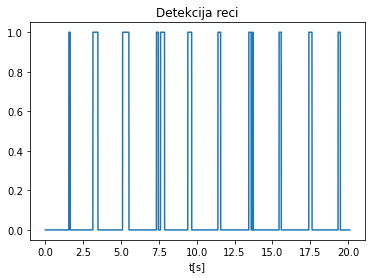

In [11]:
# sirenje uz pomoc ZCR
for i in range(len(start1)):
    for j in range(25):
        if short_time_zcr[start1[i]-j] < otsu:
            start1[i] = start1[i]-j
            break
            
for i in range(len(end1)):
    for j in range(25):
        if short_time_zcr[end1[i]+j] < otsu:
            end1[i] = end1[i]+j
            break
            
# segmentacija govora
speech = np.zeros(short_time_energy.shape)
for i in range(len(start1)):
    for j in range(start1[i], end1[i]):
        speech[j]=1

t = np.arange(speech.size)/8000
plt.plot(t, speech)
plt.title('Detekcija reci')
plt.xlabel('t[s]')

Sada je potrebno odrediti pitch periodu. Za estimaciju pitch periodu ću koristiti dve metode: metodu paralelnog procesiranja i autokorelacionu.

In [12]:
"""
audio = pyaudio.PyAudio()
stream = audio.open(format=pyaudio.paInt16, channels=1, rate=8000, input=True, frames_per_buffer=1024)
frames = []

t_end = time.time() + 4
print('Krece')
while time.time() < t_end:
    data = stream.read(1024)
    frames.append(data)
print('Kraj')
stream.stop_stream()
stream.close()
audio.terminate()

sound_file = wave.open("pitch.wav", "wb")
sound_file.setnchannels(1)
sound_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
sound_file.setframerate(8000)
sound_file.writeframes(b''.join(frames))
sound_file.close()
"""

'\naudio = pyaudio.PyAudio()\nstream = audio.open(format=pyaudio.paInt16, channels=1, rate=8000, input=True, frames_per_buffer=1024)\nframes = []\n\nt_end = time.time() + 4\nprint(\'Krece\')\nwhile time.time() < t_end:\n    data = stream.read(1024)\n    frames.append(data)\nprint(\'Kraj\')\nstream.stop_stream()\nstream.close()\naudio.terminate()\n\nsound_file = wave.open("pitch.wav", "wb")\nsound_file.setnchannels(1)\nsound_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))\nsound_file.setframerate(8000)\nsound_file.writeframes(b\'\'.join(frames))\nsound_file.close()\n'

(32768,)


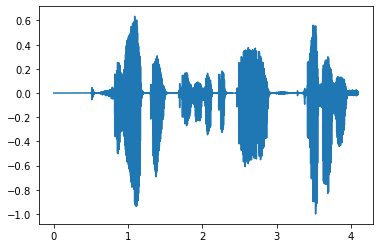

In [13]:
samplerate, data = wavfile.read("pitch.wav")
# normalizacija
data = data/np.max(abs(data))
print(data.shape)
t = np.arange(data.size)/8000
plt.plot(t, data)

Pre bilo kakve obrade potrebno je filtrirati govorni signal. Pošto se pitch frekvencija nalazi između 100Hz i 400Hz možemo da filtriramo bandpass filtrom između 60Hz i 800Hz.

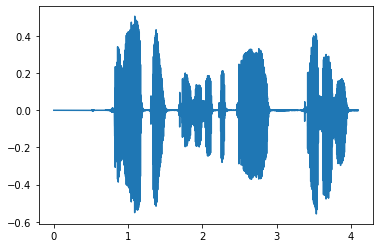

In [14]:
sos = signal.butter(4, [60, 800], btype='bandpass', analog=False, fs=8000, output='sos')
data = signal.sosfilt(sos, data)
t = np.arange(data.size)/8000
plt.plot(t, data)

### Metoda paralelnog procesiranja

In [15]:
max_peaks, _ = find_peaks(data)
min_peaks, _ = find_peaks(-data)

m1 = np.zeros(data.size)
m1[max_peaks[max_peaks>0]] = data[max_peaks[max_peaks>0]]

m2 = np.zeros(data.size)

m3 = np.zeros(data.size)
m3[max_peaks[0]] = data[max_peaks[0]]

m4 = np.zeros(data.size)
m4[min_peaks[min_peaks<0]] = -data[min_peaks[min_peaks<0]]

m5 = np.zeros(data.size)
m5[min_peaks[0]] = data[min_peaks[0]]

m6 = np.zeros(data.size)
m6[min_peaks[0]] = max(-data[min_peaks[0]], 0)

for i in range(1, max_peaks.size):
    if i<min_peaks.size:
        m2[max_peaks[i]] = max(data[max_peaks[i]] - data[min_peaks[i-1]], 0)
    m3[max_peaks[i]] = max(data[max_peaks[i]] - data[max_peaks[i-1]], 0)
    
for i in range(1, min_peaks.size):
    if i<max_peaks.size:
        m5[min_peaks[i]] = max(data[max_peaks[i]] - data[min_peaks[i]], 0)
    m6[min_peaks[i]] = max(data[min_peaks[i-1]] - data[min_peaks[i]], 0)

U kodu iznad sam odredio različite funkcije koje procenjuju pitch periodu. Te funkcije su:
$$m1_i = max(M_i, 0)$$
$$m2_i = max(M_i - m_{i-1}, 0)$$
$$m3_i = max(M_i-M_{i-1}, 0)$$
$$m4_i = max(-m_i, 0)$$
$$m5_i = max(-m_i+M_i, 0)$$
$$m6_i = max(-m_i + m_{i-1}, 0)$$
gde je $M_i$ i-ti lokalni maksimum govornog signala, a $m_i$ je i-ti lokalni minimum govornog signala. Potrebno je naći periodu ovih kvazi-periodičnih funkcija i to je njihova estimacija pitch periode.

Text(0.5, 0, 't[s]')

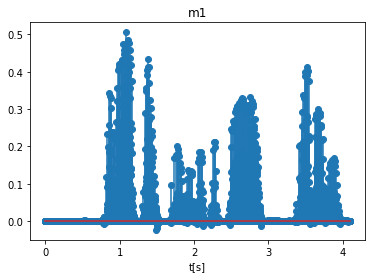

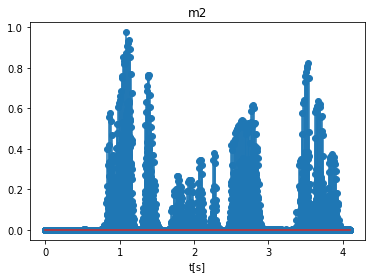

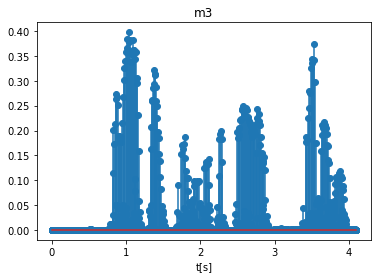

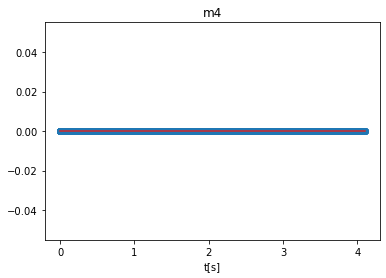

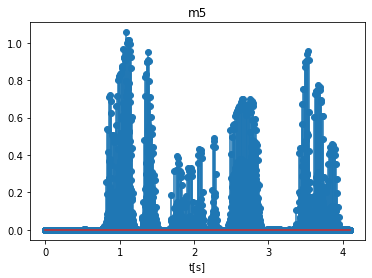

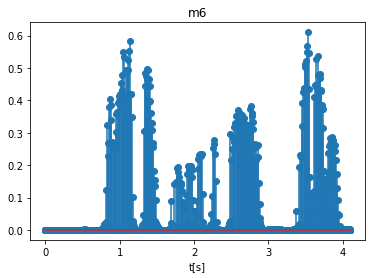

In [16]:
t = np.arange(m1.size)/8000

plt.figure()
plt.stem(t, m1)
plt.title('m1')
plt.xlabel('t[s]')

plt.figure()
plt.stem(t, m2)
plt.title('m2')
plt.xlabel('t[s]')

plt.figure()
plt.stem(t, m3)
plt.title('m3')
plt.xlabel('t[s]')

plt.figure()
plt.stem(t, m4)
plt.title('m4')
plt.xlabel('t[s]')

plt.figure()
plt.stem(t, m5)
plt.title('m5')
plt.xlabel('t[s]')

plt.figure()
plt.stem(t, m6)
plt.title('m6')
plt.xlabel('t[s]')

Za kraj je potrebno proceniti pitch periodu. Za blanking period koristim $\tau=4ms$, a za $\lambda=150s^{-1}$.

In [17]:
def pp_estimation(m: np.array, tau: int, lam: float) -> float:
    start = 0
    for i in range(m.size):
        if m[i]!=0:
            start = i
            break
    A = m[start]
    start = start+tau
    for i in range(start, m.size):
        if m[i] > A*math.exp(-lam*(i-start)/8000):
            return (i-start+tau)/8000
    return 0

In [18]:
ppe = []
tau = int(4/1000*8000)
lam = 150
wind = int(m1.size/20)
estimator = [0]
for i in range(19):
    ppe = []
    ppe.append(pp_estimation(m1[i*wind:(i+1)*wind], tau, lam))
    ppe.append(pp_estimation(m2[i*wind:(i+1)*wind], tau, lam))
    ppe.append(pp_estimation(m3[i*wind:(i+1)*wind], tau, lam))
    ppe.append(pp_estimation(m4[i*wind:(i+1)*wind], tau, lam))
    ppe.append(pp_estimation(m5[i*wind:(i+1)*wind], tau, lam))
    ppe.append(pp_estimation(m6[i*wind:(i+1)*wind], tau, lam))
    ppe.append(estimator[i])
    ppe = np.array(ppe)
    estimator.append(np.median(ppe))

Podelio sam ceo signal na 20 prozora i na njima radio estimaciju. Neki od tig prozora imaju lošu estimaciju, jer signal nije dovoljno infomrativan (npr. krenuo sam da pričam tek posle 1 sekunde pa je prvih par prozora neinformativno).

In [19]:
print(estimator)

[0, 0.00475, 0.004125, 0.00575, 0.004, 0.007375, 0.009375, 0.007125, 0.004625, 0.00525, 0.004875, 0.00525, 0.00525, 0.006, 0.006375, 0.006375, 0.0105, 0.004625, 0.00525, 0.00525]


Konačnu estimaciju bih ja uradio tako što bih uradio srednju vrednost svih estimacija.

In [20]:
estimator = np.array(estimator)
output = np.mean(estimator)
print(output, 1/output)

0.00560625 178.37235228539575


Ovaj metod vraća pitch frekvenciju od 178Hz, što je i moguće. Međutim mislim da ovi neinformativni prozori prave problem s obzirom da je frekvencija kod njih dosta visoko, jer je tu termički šum.

### Autokorelaciona metoda

Kod ove metode je potrebno prvo uraditi klipovanje kako bismo dobili mirniju autokorelacionu funkciju. Za te potrebe ću koristiti centralno klipovanje.

In [21]:
def central_clipping(arr: np.array, Cl: float) -> np.array:
    output = np.zeros(arr.size)
    output[arr<-Cl] = arr[arr<-Cl] + Cl
    output[arr>Cl] = arr[arr>Cl] - Cl
    return output

Text(0.5, 1.0, 'Centralno klipovanje')

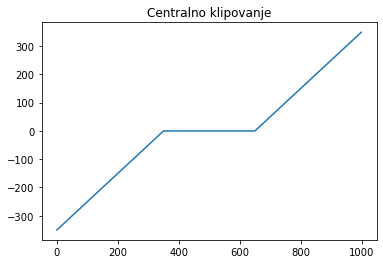

In [22]:
test = np.arange(1000)-500
out = central_clipping(test, 150)

plt.figure()
plt.plot(out)
plt.title('Centralno klipovanje')

Na ovom grafiku je prikazano kako izgleda centralno klipovanje. Funkcija central_clipping vraća klipovan niz početne funkcije, a granica za klipovanje je $C_L$ koji je drugi argument funkcije.
$C_L$ za ovaj problem sam izabrao kao $30\% \cdot X_{max}$.

0.15173569625413777


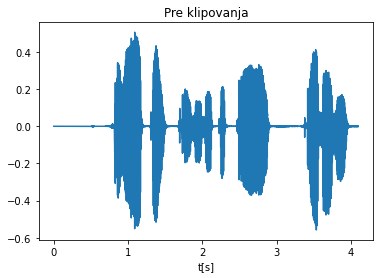

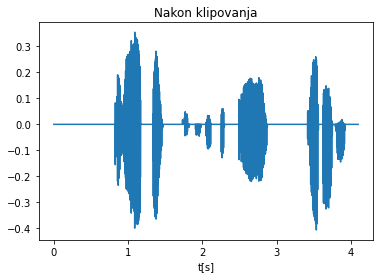

In [23]:
Xmax = np.max(data)
Cl = 0.3*Xmax
out = central_clipping(data, Cl)
t = np.arange(data.size)/8000

plt.figure()
plt.title('Pre klipovanja')
plt.plot(t, data)
plt.xlabel('t[s]')

plt.figure()
plt.title('Nakon klipovanja')
plt.plot(t, out)
plt.xlabel('t[s]')

print(Cl)

## Zadatak 3
Da bismo definisali skriveni Markovljev model moramo da definišemo matricu verovatnoća prelaza iz jednog stanja u drugo $A$, matricu $B$ koja govori o verovatnoći izvlačenja određenih kuglica u određenom stanju, i matricu verovatoća početnog stanja $\Pi$.
$$A = \begin{bmatrix}
1−3𝑎 & 𝑎 & 2𝑎 \\
b & 1-2b & b\\
0.1 & 0.1 & 0.8
\end{bmatrix}$$

$$
B = \begin{bmatrix}
0.625 & 0.25 & 0.125 \\
\frac{2}{13} & \frac{7}{13} & \frac{4}{13}\\
0.1 & 0.3 & 0.6
\end{bmatrix}
$$

$$\Pi = \begin{bmatrix} \frac{1}{3} & \frac{1}{3} & \frac{1}{3} \end{bmatrix} $$

In [24]:
def first_problem(a: float, b: float, O: np.array) -> float:
    A = np.array([[1-3*a, a, 2*a],[b, 1-2*b, b], [0.1, 0.1, 0.8]])
    B = np.array([[0.625, 0.25, 0.125], [2/13, 7/13, 4/13], [0.1, 0.3, 0.6]])
    Pi = np.array([1/3, 1/3, 1/3])
    # inicijalizacija
    alpha = np.zeros(3)
    alpha = Pi*B[:, O[0]]
    
    #incukcija
    for i in range(1, O.size):
        a1 = np.copy(alpha)
        alpha[0] = (a1[0]*A[0, 0] + a1[1]*A[1, 0] + a1[2]*A[2, 0])*B[0, O[i]]
        alpha[1] = (a1[0]*A[0, 1] + a1[1]*A[1, 1] + a1[2]*A[2, 1])*B[1, O[i]]
        alpha[2] = (a1[0]*A[0, 2] + a1[1]*A[1, 2] + a1[2]*A[2, 2])*B[2, O[i]]
    
    # terminacija
    return np.sum(alpha)

In [25]:
def argmax(a: float, b: float, c:float) -> int:
    if a >= b and a >= c:
        return 0
    if b >= c:
        return 1
    return 2

def second_problem(a: float, b: float, O: np.array) -> np.array:
    A = np.array([[1-3*a, a, 2*a],[b, 1-2*b, b], [0.1, 0.1, 0.8]])
    B = np.array([[0.625, 0.25, 0.125], [2/13, 7/13, 4/13], [0.1, 0.3, 0.6]])
    Pi = np.array([1/3, 1/3, 1/3])
    
    # inicijalizacija
    delta = np.zeros([100, 3])
    delta[0, :] = Pi*B[:, O[0]]
    states = np.zeros([100, 3])
    
    # rekurzija
    for i in range(1, O.size):
        d1 = np.copy(delta[i-1, :])
        delta[i, 0] = max(d1[0]*A[0, 0], d1[1]*A[1, 0], d1[2]*A[2, 0]) * B[0, O[i]]
        delta[i, 1] = max(d1[0]*A[0, 1], d1[1]*A[1, 1], d1[2]*A[2, 1]) * B[1, O[i]]
        delta[i, 2] = max(d1[0]*A[0, 2], d1[1]*A[1, 2], d1[2]*A[2, 2]) * B[2, O[i]]
        delta[i, :] = delta[i, :]/np.sum(delta[i,:])
        
        states[i, 0] = argmax(d1[0]*A[0, 0], d1[1]*A[1, 0], d1[2]*A[2, 0])
        states[i, 1] = argmax(d1[0]*A[0, 1], d1[1]*A[1, 1], d1[2]*A[2, 1])
        states[i, 2] = argmax(d1[0]*A[0, 2], d1[1]*A[1, 2], d1[2]*A[2, 2])
        
    # terminacija
    states = states.astype('int32')
    q = np.zeros(O.size, dtype = 'int32')
    for i in range(O.size):
        q[i] = argmax(delta[i, 0], delta[i, 1], delta[i, 2])
    
    # path-tracking
    i = int(O.size-2)
    while i>=0:
        q[i] = states[i+1, q[i+1]]
        i = i-1
    return q

Ovo su dve funkcije koje vraćaju rešenje prvog i drugog problema. Prvi problem je koja je verovatnoća da će se desiti ovakve opservacije. On se rešava forward procedurom, odnosno:

1) inicijalizacija: $\alpha_1(j) = \Pi_j \cdot b_j(O_1)$

2) indukcija: $\alpha_{t+1}(j) = [\sum^{N}_{i=1} \alpha_t(i)* a_{ij}]b_j(O_{t+1})$

3) terminacija: $P(O|\lambda) = \sum^{N}_{i=1}\alpha_T(i)$

Drugi problem je vraćanje najverovatnije sekvence, a to se radi Viterby-jevim algoritmom, odnosno:

1) Inicijalizacija: $\delta_1 = \Pi_1 \cdot B_j(O_1)$; $\psi_1(j)=0$

2) Rekurzija: $\delta_t(j) = max(\delta_{t-1}\cdot a_{ij})b_j(O_t)$; $\psi_t(j) = argmax(\delta_{t-1}\cdot a_{ij})$

3) Terminacija: $P^* = max(\delta_T(i))$; $q^{*}_T = argmax(\delta_T(i))$

4) path-backtracking: $q^{*}_t = \psi_{t+1}(q^{*}_{t+1})$

In [28]:
a = 0.05
b = 0.1
O = np.random.rand(100)*3
O = np.floor(O)
O = O.astype('int32')
O[O==3] = 2
print("Verovatnoca: ", first_problem(a, b, O))
print("Opservacije: ", O)
print("Stanja: ", second_problem(a, b, O))

Verovatnoca:  3.693852158762679e-50
Opservacije:  [2 2 1 0 0 2 1 1 2 0 2 0 1 0 1 2 2 2 0 0 1 1 0 2 1 0 1 2 0 0 2 0 2 0 0 1 0
 2 1 1 2 1 1 2 2 1 1 1 2 1 0 1 2 0 0 1 1 0 2 2 1 0 1 0 0 2 0 2 1 2 2 1 0 2
 2 2 1 1 2 1 1 1 0 1 1 2 0 1 2 0 1 0 0 0 2 0 1 1 1 1]
Stanja:  [2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1]


In [30]:
a = 0.2
b = 0.33
print("Verovatnoca: ", first_problem(a, b, O))
print("Opservacije: ", O)
print("Stanja: ", second_problem(a, b, O))

Verovatnoca:  7.750559666157486e-51
Opservacije:  [2 2 1 0 0 2 1 1 2 0 2 0 1 0 1 2 2 2 0 0 1 1 0 2 1 0 1 2 0 0 2 0 2 0 0 1 0
 2 1 1 2 1 1 2 2 1 1 1 2 1 0 1 2 0 0 1 1 0 2 2 1 0 1 0 0 2 0 2 1 2 2 1 0 2
 2 2 1 1 2 1 1 1 0 1 1 2 0 1 2 0 1 0 0 0 2 0 1 1 1 1]
Stanja:  [2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 0 0 2 2 2 0 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2]
